# **GD06. WEAT를 활용하여 임베딩 내 편향성 알아보기**

**INDEX**

00. 사용할 모듈 가져오기

01. 데이터 가져오기

02. Embedding Model 생성

03. target, attribute 단어 set 생성

04. WEAT score 구하기

05. 회고

---

## **00. 사용할 모듈 가져오기**

In [3]:
# pip install konlpy

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf

import konlpy
import gensim
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

import gzip
import os
from gensim.models import KeyedVectors
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(sns.__version__)

0.6.0
3.6.0
1.0.2
0.11.2


In [5]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


## **01. 데이터 가져오기**

In [6]:
data_path = '/content/mydrive/MyDrive/AIFFEL/GoingDeeper/GD05_06/unzip_data/synopsis.txt'

print("Done!")

Done!


In [7]:
# 읽어오는 과정에서 명사만 추출하는 함수 생성
tokenized = []
okt = Okt()
def loader_get_nouns(data_path):
    with open(data_path, 'r') as f:
        while True:
            line = f.readline()
            if not line: break
            words = okt.pos(line, stem=True, norm=True)
            res = []
            for w in words:
                if w[1] in ['Noun']:
                    res.append(w[0])
            tokenized.append(res)
    return tokenized

print("Done!")

Done!


In [8]:
nouns = loader_get_nouns(data_path)

---

## **02. Embedding Model 생성**

In [9]:
## gensim 4.0 기준
# model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
# model.wv.most_similar(positive=['영화'])

## gensim 3.X 
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.most_similar(positive=['영화'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


[('작품', 0.9012084007263184),
 ('다큐멘터리', 0.8576816320419312),
 ('드라마', 0.8415915966033936),
 ('형식', 0.8280462026596069),
 ('영화로', 0.8252614736557007),
 ('감동', 0.815281867980957),
 ('스토리', 0.8084328770637512),
 ('코미디', 0.8040423393249512),
 ('소재', 0.7932438850402832),
 ('주제', 0.790687084197998)]

In [10]:
# test
model.wv.most_similar(positive=['사랑'])

[('정일', 0.7350336313247681),
 ('애정', 0.7341237664222717),
 ('우정', 0.7279262542724609),
 ('만남', 0.7229673266410828),
 ('행복', 0.7212333679199219),
 ('진심', 0.7121315002441406),
 ('시빌라', 0.7015416622161865),
 ('고백', 0.701117992401123),
 ('운명', 0.6987417340278625),
 ('연애', 0.6966538429260254)]

In [11]:
# test
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.9023271203041077),
 ('뮤지컬영화', 0.8952600955963135),
 ('영감', 0.892842710018158),
 ('오페라', 0.8916624188423157),
 ('데뷔', 0.8881603479385376),
 ('시나리오', 0.8829681873321533),
 ('캐스팅', 0.880712628364563),
 ('배우', 0.8797051906585693),
 ('각색', 0.8779683113098145),
 ('예술가', 0.8768812417984009)]

어느 정도 납득할만한 결과가 나온 것 같습니다.

---

## **03. target, attribute 단어set 생성**

In [12]:
# target
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_path, file_name):
    okt = Okt()
    result = []
    with open(file_path+file_name, 'r') as fread: 
        print('파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("Done!")

Done!


In [13]:
file_path = '/content/mydrive/MyDrive/AIFFEL/GoingDeeper/GD05_06/unzip_data/'

art = read_token(file_path, art_txt)
gen = read_token(file_path, gen_txt)

파일을 읽고 있습니다.
파일을 읽고 있습니다.


In [14]:
# TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [15]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

겹치는 단어가 많습니다. 제거해줍니다.

In [16]:
n = 30
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 30개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 30개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [17]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린', '연인']


In [18]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체', '한국']


In [19]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

print("Done!")

Done!


In [20]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_path, file_name))

파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.
파일을 읽고 있습니다.


In [21]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [22]:
# 각 장르별 단어 추출
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작, 위해, 사람, 살인, 

직관적으로 보았을 때 나름 납득할 수 있는 속성들로 이루어져 있습니다.

코미디-판타지처럼 대표 단어가 유사한 케이스도 있지만, 곰곰이 생각해보면 실제로 판타지에서 요괴와 소녀를 빼고 친구와 가족을 더하면 코미디가 된다고도 볼 수 있습니다.

또한 기본적으로 영화의 구성요소들(등장인물, 사건, 플롯)은 장르에 상관없이 어느 정도 겹치는 경향이 있습니다.

따라서 별도의 추가적인 중복 제거 처리는 하지 않아도 될 것 같습니다.

---

## **04. WEAT Score 구하기**

In [23]:
def cos_sim(i, j):
    return np.dot(i, j.T)/(np.linalg.norm(i)*np.linalg.norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

print("Done!")

Done!


In [24]:
# weat scoring 함수 생성
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print("Done!")

Done!


In [25]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("Done!")

Done!


In [26]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

print("Done!")

Done!


In [27]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.53923637
SF 공연 -0.39143968
SF 공포(호러) -0.7984004
SF 기타 0.3510243
SF 다큐멘터리 0.6188335
SF 드라마 -0.4424764
SF 멜로로맨스 -0.8621722
SF 뮤지컬 0.33163
SF 미스터리 -0.7918762
SF 범죄 -0.3925976
SF 사극 -0.8441387
SF 서부극(웨스턴) -0.4578087
SF 성인물(에로) -0.673389
SF 스릴러 -0.6415403
SF 애니메이션 0.37153327
SF 액션 -0.5824641
SF 어드벤처 -0.79442644
SF 전쟁 0.15495215
SF 코미디 -0.547789
SF 판타지 -0.23884903
가족 공연 0.2134434
가족 공포(호러) -0.2676027
가족 기타 0.78387237
가족 다큐멘터리 0.8679939
가족 드라마 0.1832483
가족 멜로로맨스 -0.7166728
가족 뮤지컬 0.7270166
가족 미스터리 -0.40657467
가족 범죄 0.07000123
가족 사극 -0.071920104
가족 서부극(웨스턴) 0.43075472
가족 성인물(에로) -0.43788862
가족 스릴러 -0.25432786
가족 애니메이션 0.90884745
가족 액션 0.015871905
가족 어드벤처 8.784196e-05
가족 전쟁 0.6600043
가족 코미디 0.12707825
가족 판타지 0.4412425
공연 공포(호러) -0.3376531
공연 기타 0.9799069
공연 다큐멘터리 0.9681901
공연 드라마 -0.06724868
공연 멜로로맨스 -0.79358745
공연 뮤지컬 0.91881305
공연 미스터리 -0.443925
공연 범죄 -0.053004242
공연 사극 -0.39127547
공연 서부극(웨스턴) 0.018607665
공연 성인물(에로) -0.6121965
공연 스릴러 -0.31853595
공연 애니메이션 0.9633822
공연 액션 -0.11791669
공

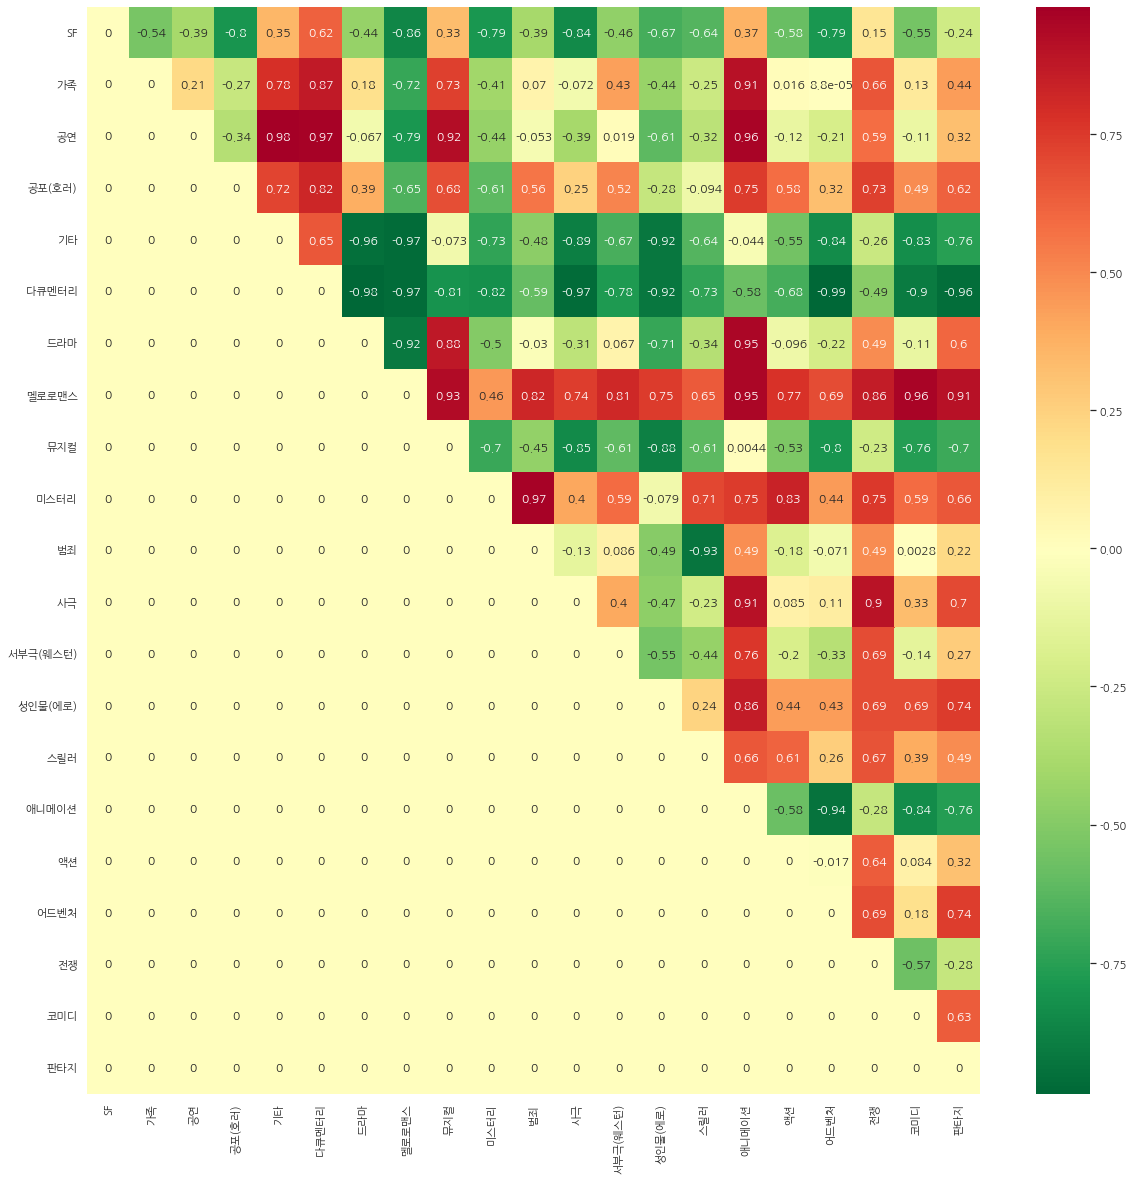

In [29]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(20, 20))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

다큐멘터리, 멜로로맨스, 미스터리처럼 상대적으로 클리셰가 굳어져 있는 장르는 편향성이 확실하게 나타나는 것을 볼 수 있습니다.

---

## **05. 회고**

- 이번에는 장르의 특성이 사용하는 단어의 빈도로 표현될 수 있다는 아이디어에 착안하여 TF-IDF를 사용하였지만, Word2Vec 모델을 사용하여 얻은 워드 임베딩을 가지고 지식그래프를 만들어서 노드와 엣지의 관계를 보고 각 장르별 유사도를 측정할 수도 있다고 생각됩니다.

- 다만 아직 그래프 이론과 지식 그래프 구현체를 깊이 공부하지 않아서 실제로 구현해보지는 못했습니다.